In [225]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

## Generate fake

In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def normalize(x):
    x_min = x.min()
    x_max = x.max()
    
    x = (x-x_min)/(x_max -x_min)
    return x

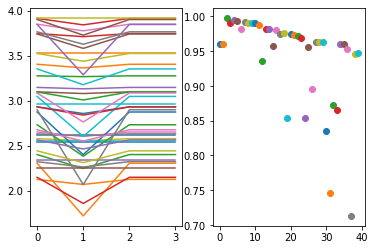

In [192]:
time_steps = 40
n_cells = 4 # Amount of cells in pack
x = np.zeros([time_steps,n_cells])


fig, ax = plt.subplots(1,2)

failed_cell = 1 # Which cell is the failing cell
is_fail = True# Does the pack include a failed cell
volt_stochastic = 0.9
for i in range(time_steps):
    sigma = 0.0 # How much is the fluctuation
    median = random.uniform(2, 4)
    volt = np.random.normal(loc=median, scale=sigma, size=n_cells)
    if is_fail:
        r = random.random()
        if r < volt_stochastic:
            stochstic_amplifier = random.randint(100,1000)
            
            y = (1-i/stochstic_amplifier)
            #print(y)
            volt[failed_cell]*=y
    ax[1].scatter(i,y)
    x[i,:] = volt
            
    ax[0].plot(volt, label=i)
#plt.ylim(0,16)
#plt.legend()

In [193]:
def create_sequence(time_steps=40, n_cells=4, failed_cell=1, is_fail=True, sigma=0.0, volt_stochastic = 0.9, normalize_x=False):
    x = np.zeros([time_steps,n_cells])
    for i in range(time_steps):
        median = random.uniform(2, 4)
        volt = np.random.normal(loc=median, scale=sigma, size=n_cells)
        if is_fail:
            r = random.random()
            if r < volt_stochastic:
                stochstic_amplifier = random.randint(100,1000)

                y = (1-i/stochstic_amplifier)
                #print(y)
                volt[failed_cell]*=y
        x[i,:] = volt
    if normalize_x:
        x = normalize(x)
    if is_fail:
        label = 1
    else:
        label = 0
    return x, label
    

In [202]:
x,y = create_sequence(time_steps=6, n_cells=4, failed_cell=1, is_fail=True, sigma=0.0, volt_stochastic = 0.9, normalize_x=True)

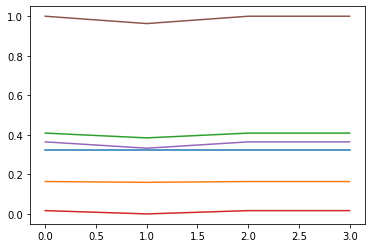

In [203]:
plt.plot(x.T)
plt.show()

In [262]:
def creata_data(n_healthy=2, n_fails=2):
    data = []
    for i in range(n_healthy+n_fails):
        if i >= n_healthy:
            fail=True
        else:
            fail=False
        x,y = create_sequence(time_steps=6, n_cells=4, failed_cell=1, is_fail=fail, sigma=0.0, volt_stochastic = 0.9, normalize_x=False)
        data.append((torch.FloatTensor(x),y))
    return data
    

In [274]:
data = creata_data(n_healthy=100, n_fails=100)

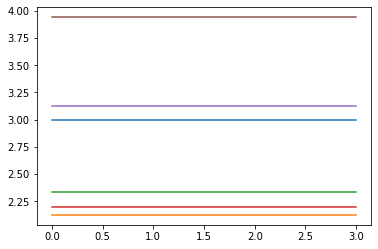

In [275]:
plt.plot(data[2][0].T)

In [226]:
## Create dataset

In [276]:
train_size = int(len(data)*0.8)
test_size = len(data) - train_size
train_set, test_set = torch.utils.data.random_split(data,[train_size, test_size])
batch_size = 10
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True,drop_last=True)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True,drop_last=True)

In [277]:
timestep = 6
n_cells = 4

In [278]:
class ANNMultilayerperceptron(nn.Module):

    def __init__(self, input_size=(timestep*n_cells),output_size=2, layers=[220,84]):  # 120, 84
        super().__init__()

        self.fc1 = nn.Linear(input_size, layers[0])
        self.fc2 = nn.Linear(layers[0], layers[1])
        self.fc2b = nn.Linear(layers[1], 500)
        self.fc2c = nn.Linear(500, layers[1])
        self.fc2d = nn.Linear(layers[1], layers[1])
        self.fc3 = nn.Linear(layers[1], output_size)

    def forward(self,X):
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.relu(self.fc2b(X))
        X = F.relu(self.fc2c(X))
        X = F.relu(self.fc2d(X))
        X = self.fc3(X)

        return F.log_softmax(X,dim=1) # PGA multiclass classification
        #return X

In [279]:
model = ANNMultilayerperceptron()
model

ANNMultilayerperceptron(
  (fc1): Linear(in_features=24, out_features=220, bias=True)
  (fc2): Linear(in_features=220, out_features=84, bias=True)
  (fc2b): Linear(in_features=84, out_features=500, bias=True)
  (fc2c): Linear(in_features=500, out_features=84, bias=True)
  (fc2d): Linear(in_features=84, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

In [280]:
model(X_train.view(batch_size, -1)) 

tensor([[-0.6995, -0.6869],
        [-0.7001, -0.6862],
        [-0.7011, -0.6852],
        [-0.7013, -0.6850],
        [-0.7001, -0.6863],
        [-0.6977, -0.6886],
        [-0.6989, -0.6875],
        [-0.7002, -0.6861],
        [-0.6996, -0.6867],
        [-0.7006, -0.6857]], grad_fn=<LogSoftmaxBackward0>)

In [281]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
#optimizer = torch.optim.Adadelta(model.parameters(), lr=0.001)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [285]:
#from ignite.metrics import Precision, Recall
#from ignite.metrics import Precision ### LÄGG TILL IGNITE
#train_precision = Precision()
#train_recall = Recall()

#test_precision = Precision()
#test_recall = Recall()
# https://pytorch.org/ignite/metrics.html


epochs = 100

train_losses = []
test_losses = []
train_correct = []
test_correct = []

# For loop epochs 

for i in range(epochs):
    trn_correct = 0
    tst_correct = 0 

    # Train

    for b, (X_train, y_train) in enumerate(train_loader):
        
        # Skip iteration if batch size not equal to stated dim
        
            
        #print(X_train.shape, y_train.shape) 
        
        b += 1
        
        y_pred = model(X_train.view(batch_size, -1))  # Flatten input
        lossTrain = criterion(y_pred, y_train)

        predicted = torch.max(y_pred.data,1)[1]

        #calculate precision and recall
        #train_precision.update((y_pred, y_train))
        #train_recall.update((y_pred, y_train))
      

        batch_corr = (predicted == y_train).sum()
        trn_correct += batch_corr

        optimizer.zero_grad()
        lossTrain.backward()
        optimizer.step()

        #if b%2 == 0:
           #print(f"Epoch {i} Batch: {b} Train Loss: {lossTrain.item()}")

    train_losses.append(lossTrain.data.item())
    train_correct.append(trn_correct)

    # Test
    with torch.no_grad():
        for b, (X_test,y_test) in enumerate(test_loader):
            y_val = model(X_train.view(batch_size, -1))

            predicted = torch.max(y_val.data,1)[1]

            #calculate precision and recall
            #test_precision.update((y_val, y_test))
            #test_recall.update((y_val, y_test))
            
            loss = criterion(y_val, y_test)
            test_losses.append(loss)
            test_correct.append(trn_correct)

        #if b%5 == 0:
        print(f"Epoch {i} Batch: {b} Train Loss: {lossTrain.item()} Validation Loss: {loss.item()}")


Epoch 0 Batch: 3 Train Loss: 0.5675199627876282 Validation Loss: 0.9785798788070679
Epoch 1 Batch: 3 Train Loss: 0.44741731882095337 Validation Loss: 0.6120001077651978
Epoch 2 Batch: 3 Train Loss: 0.6529837250709534 Validation Loss: 0.6428552269935608
Epoch 3 Batch: 3 Train Loss: 0.5265693664550781 Validation Loss: 0.8299350738525391
Epoch 4 Batch: 3 Train Loss: 0.47243157029151917 Validation Loss: 1.0115145444869995
Epoch 5 Batch: 3 Train Loss: 0.46460962295532227 Validation Loss: 1.0895553827285767
Epoch 6 Batch: 3 Train Loss: 0.5084768533706665 Validation Loss: 0.8636506795883179
Epoch 7 Batch: 3 Train Loss: 0.5343739986419678 Validation Loss: 0.6562329530715942
Epoch 8 Batch: 3 Train Loss: 0.4411562979221344 Validation Loss: 0.9170506596565247
Epoch 9 Batch: 3 Train Loss: 0.36847302317619324 Validation Loss: 1.2745780944824219
Epoch 10 Batch: 3 Train Loss: 0.5119544267654419 Validation Loss: 1.0083653926849365
Epoch 11 Batch: 3 Train Loss: 0.8478456735610962 Validation Loss: 0.786

Epoch 99 Batch: 3 Train Loss: 0.4120018482208252 Validation Loss: 1.1716831922531128


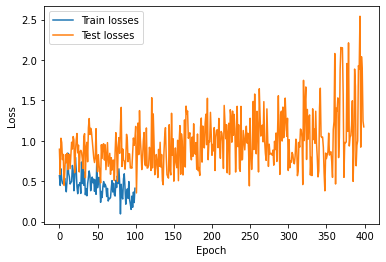

In [287]:
plt.plot(train_losses, label="Train losses")
plt.plot(test_losses, label= "Test losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

In [288]:
import numpy as np
for _ in range(100):
    # Select random sample
    i = np.random.randint(1,len(test_set))
    x = test_set[i][0]
    y = test_set[i][1]


    # Evaluate on sample
    model.eval()
    with torch.no_grad():
        new_pred =model(x.view(1,-1))
        pred_int = int(torch.max(new_pred.data,1)[1])
    print(f"Random sample {i} selected with state {y}. Model predict state is {pred_int}")

Random sample 25 selected with state 0. Model predict state is 1
Random sample 3 selected with state 0. Model predict state is 1
Random sample 34 selected with state 0. Model predict state is 1
Random sample 8 selected with state 1. Model predict state is 0
Random sample 26 selected with state 1. Model predict state is 1
Random sample 13 selected with state 1. Model predict state is 1
Random sample 36 selected with state 1. Model predict state is 0
Random sample 23 selected with state 0. Model predict state is 1
Random sample 22 selected with state 1. Model predict state is 0
Random sample 6 selected with state 0. Model predict state is 1
Random sample 6 selected with state 0. Model predict state is 1
Random sample 19 selected with state 0. Model predict state is 1
Random sample 18 selected with state 0. Model predict state is 1
Random sample 28 selected with state 0. Model predict state is 1
Random sample 24 selected with state 0. Model predict state is 1
Random sample 22 selected wit

In [289]:
import numpy as np
for _ in range(100):
    # Select random sample
    i = np.random.randint(1,len(train_set))
    x = train_set[i][0]
    y = train_set[i][1]


    # Evaluate on sample
    model.eval()
    with torch.no_grad():
        new_pred =model(x.view(1,-1))
        pred_int = int(torch.max(new_pred.data,1)[1])
    print(f"Random sample {i} selected with state {y}. Model predict state is {pred_int}")

Random sample 129 selected with state 0. Model predict state is 0
Random sample 53 selected with state 1. Model predict state is 1
Random sample 28 selected with state 1. Model predict state is 1
Random sample 14 selected with state 0. Model predict state is 0
Random sample 107 selected with state 1. Model predict state is 1
Random sample 97 selected with state 0. Model predict state is 0
Random sample 5 selected with state 0. Model predict state is 0
Random sample 73 selected with state 1. Model predict state is 1
Random sample 6 selected with state 0. Model predict state is 0
Random sample 72 selected with state 0. Model predict state is 1
Random sample 115 selected with state 0. Model predict state is 0
Random sample 8 selected with state 1. Model predict state is 1
Random sample 61 selected with state 0. Model predict state is 0
Random sample 61 selected with state 0. Model predict state is 0
Random sample 113 selected with state 1. Model predict state is 1
Random sample 118 select